In [128]:
import pandas as pd
import numpy as np

**Data Summaries**

In [165]:
df_insurance = pd.read_csv("https://www.dropbox.com/s/bocjjyo1ehr5auz/insurance_costs_1.csv?dl=1")
df_insurance.head()

,age,sex,bmi,smoker,region,charges
0,19,female,27.900,yes,southwest,16884.92400
1,33,male,22.705,no,northwest,21984.47061
2,32,male,28.880,no,northwest,3866.85520
3,31,female,25.740,no,southeast,3756.62160
4,60,female,25.840,no,northwest,28923.13692


In [130]:
df_insurance["age"].describe()

count    431.000000
mean      37.960557
std       16.363909
min       18.000000
25%       22.000000
50%       34.000000
75%       55.000000
max       64.000000
Name: age, dtype: float64

In [131]:
df_insurance["sex"].value_counts(normalize=True)

sex
female    0.522042
male      0.477958
Name: proportion, dtype: float64

In [132]:
df_insurance["bmi"].describe()

count    431.000000
mean      30.768898
std        6.111362
min       15.960000
25%       26.357500
50%       30.590000
75%       35.272500
max       49.060000
Name: bmi, dtype: float64

In [133]:
df_insurance["smoker"].value_counts(normalize=True)

smoker
no     0.798144
yes    0.201856
Name: proportion, dtype: float64

In [134]:
df_insurance["region"].value_counts(normalize=True)

region
southeast    0.290023
northeast    0.250580
southwest    0.238979
northwest    0.220418
Name: proportion, dtype: float64

In [135]:
df_insurance["charges"].describe()

count      431.000000
mean     12297.098118
std      11876.527128
min       1131.506600
25%       2710.444575
50%       9866.304850
75%      14510.872600
max      55135.402090
Name: charges, dtype: float64

There are no current concerns with the data. Any concerns wil be solved/fixed in later steps.

**Comparing the Response Variable (Changes) to Predictors**

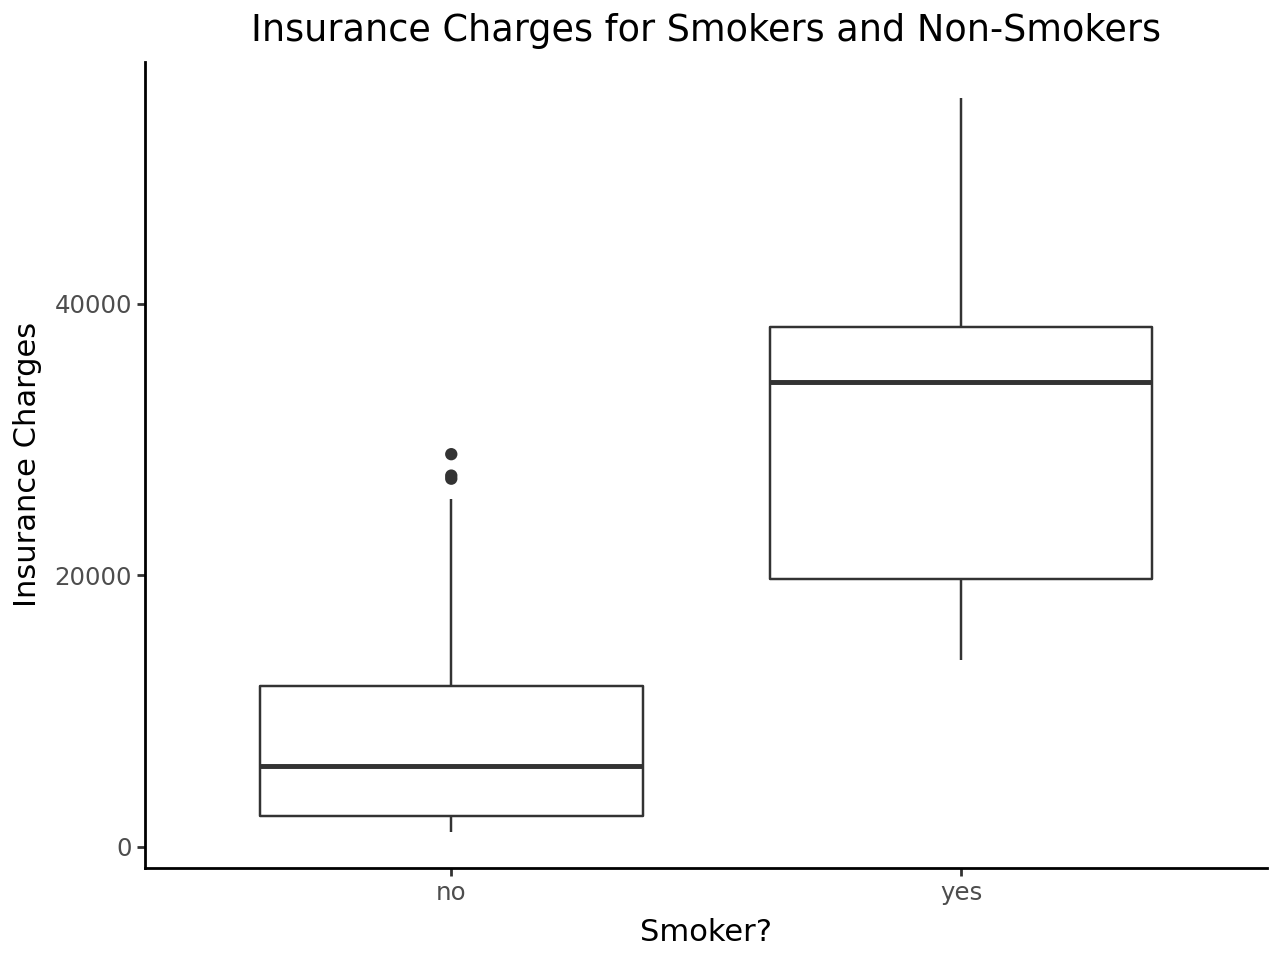

In [136]:
from plotnine import aes, ggplot, geom_boxplot, labs, theme_classic

(ggplot(df_insurance, aes(x="smoker", y="charges")) +
geom_boxplot() +
labs(x="Smoker?", y="Insurance Charges", 
     title="Insurance Charges for Smokers and Non-Smokers") +
theme_classic())

There is a noticeable effect on smoking and insurance costs. If an individual is a smoker, their average insurance cost is significantly higher than a non-smoker.

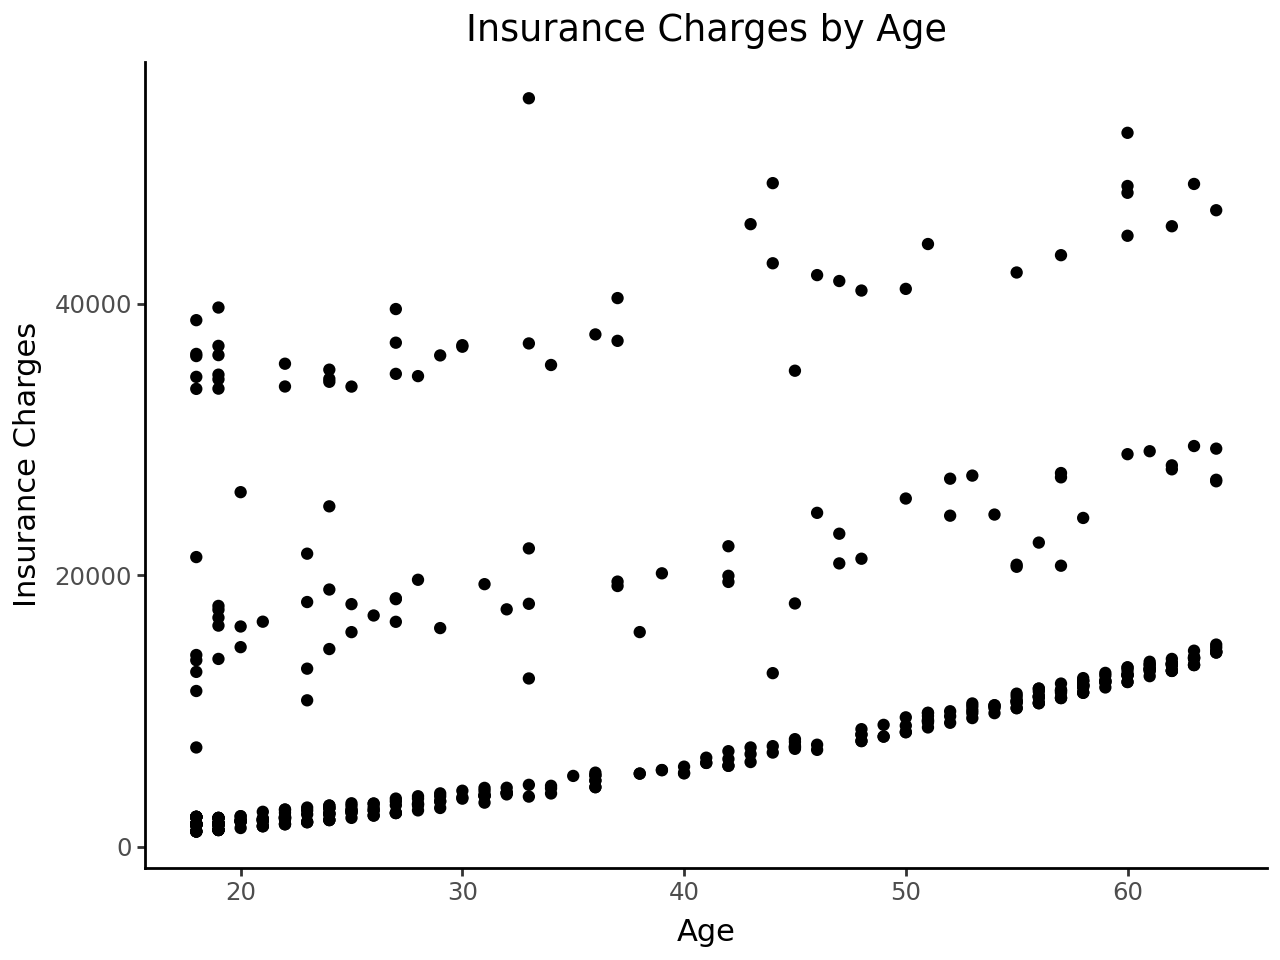

In [137]:
from plotnine import geom_point

(ggplot(df_insurance, aes(x="age", y="charges")) +
geom_point() +
labs(x="Age", y="Insurance Charges", 
     title="Insurance Charges by Age") +
theme_classic())

There appears to be a trend between age and insurance costs. It is not as noticeable as smoking, but there does appear to be a correlation: as age increases, insurance costs do as well.

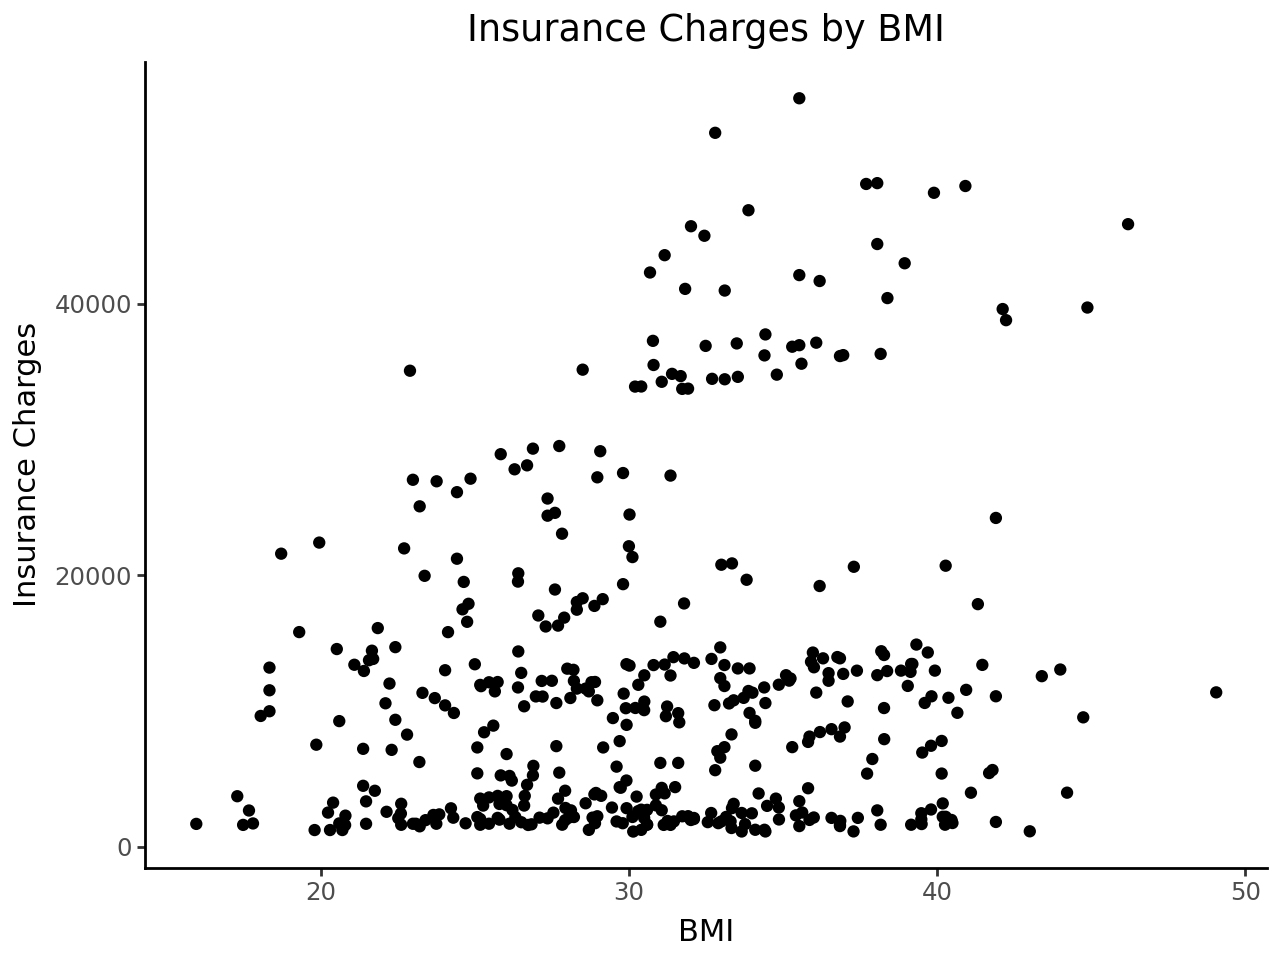

In [138]:
from plotnine import geom_point

(ggplot(df_insurance, aes(x="bmi", y="charges")) +
geom_point() +
labs(x="BMI", y="Insurance Charges", 
     title="Insurance Charges by BMI") +
theme_classic())

All extremely high insurance costs, say greater than $40,000, are charged to individuals with about a BMI of 30 or greater.The average BMI is 30.7 so this information might not be very telling. There is a trend here, but not as strong as the last two predictors.

**Part Two: Simple Linear Models**

In [139]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, FunctionTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score

In [140]:
df_insurance["age^2"] = df_insurance["age"]**2

X = df_insurance.drop("charges", axis=1)
y = df_insurance[["charges"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=23)

In [141]:
ct = ColumnTransformer(
  [
    ("standardize", StandardScaler(), ["age"])
  ],
  remainder = "drop"
)

pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("linear_regression", LinearRegression())]
).set_output(transform="pandas")

pipeline1_fit = pipeline_1.fit(X_train, y_train)
test_pred = pipeline_1.predict(X_test)
train_pred = pipeline_1.predict(X_train)

In [142]:
rmse_test_1 = np.sqrt(mean_squared_error(test_pred, y_test))
r2_test_1 = r2_score(test_pred, y_test)

print(rmse_test_1, r2_test_1)
pipeline1_fit.named_steps['linear_regression'].coef_

9945.355886132365 -6.111336432821362
9945.355886132365 -6.111336432821362


array([[3835.06877759]])

We have a root mean square error of 9945.36, meaning that, on average, our model is missing the true insurance costs by $9,945.36.

I used standard scalar, so the coefficient for age, 3835, represents the dollar change in insurance costs by one standard deviation of age. Recall from earlier summary statistics that one standard deviation in age is about 16 years. So for every 16 year increase in age, insurance costs are expected to increase by 3835.

In [143]:
ct2 = ColumnTransformer(
  [
    ("dummify", OneHotEncoder(sparse_output = False, drop="first"), ["sex"]),
    ("standardize", StandardScaler(), ["age"])
  ],
  remainder = "drop"
)

pipeline_2 = Pipeline(
  [("preprocessing", ct2),
  ("linear_regression", LinearRegression())]
).set_output(transform="pandas")

pipeline2_fit = pipeline_2.fit(X_train, y_train)
test_pred = pipeline_2.predict(X_test)
train_pred = pipeline_2.predict(X_train)

rmse_test_2 = np.sqrt(mean_squared_error(test_pred, y_test))
r2_test_2 = r2_score(test_pred, y_test)

print(rmse_test_2, r2_test_2)
pipeline2_fit.named_steps['linear_regression'].coef_

10004.218240880655 -5.961112396425042
10004.218240880655 -5.961112396425042


array([[1241.37024496, 3826.24384695]])

The coefficent of 1241.37 applies to males in the dataset, as female is the reference category. This means that, holding age constant, being a male is associated with an increase of $1,241 in insurance costs. Because we applied standard scalar to age, 3826 represents the dollar change in insurance costs by one standard deviation of age. Recall from earlier summary statistics that one standard deviation in age is about 16 years. So for every 16 year increase in age, insurance costs are expected to increase by $3,826, holding sex constant.

The root mean square error is 10004 - which is just a little higher than the previous model. On average, this model is missing the true insurance costs by $10,004 on average.

In [144]:
ct3 = ColumnTransformer(
  [
    ("dummify", OneHotEncoder(sparse_output = False, drop="first"), ["smoker"]),
    ("standardize", StandardScaler(), ["age"])
  ],
  remainder = "drop"
)

pipeline_3 = Pipeline(
  [("preprocessing", ct3),
  ("linear_regression", LinearRegression())]
).set_output(transform="pandas")

pipeline3_fit = pipeline_3.fit(X_train, y_train)
test_pred = pipeline_3.predict(X_test)
train_pred = pipeline_3.predict(X_train)

rmse_test_3 = np.sqrt(mean_squared_error(test_pred, y_test))
r2_test_3 = r2_score(test_pred, y_test)

print(rmse_test_3, r2_test_3)
pipeline3_fit.named_steps['linear_regression'].coef_

5599.013266796962 0.6673041512687419
5599.013266796962 0.6673041512687419


array([[24728.7253723 ,  3981.23990194]])

The root mean square error has decreased from the previous models. Now it is at 5599.01, meaning that on average we are missing the true insurance costs by $5,559.01 with smoker and age as our predictors.

The coefficient for smoker is 24728 - much higher than any other coefficient we have seen so far. Being a smoker is asscociated with $24,728 more in insurance costs, on average, than being a non-smoker, holding age constant.

4. The debate between Model 2 and Model 3 has been discussed a little bit prior in this notebook. Just looking at root mean squared error, Model 3 is closer at predicting the true insurance cost.

Once R-squared gets involved, it is very clear to see which model is better. Model 3's test set has a R-squared of 0.667, meaning that two thirds of the variation in insurance costs in the test set, is explained by whether an individual smokes and their age.

Model 2 has a R-squared of -5.9. This means that this model performs much worse than if we just took the mean of the insurance costs.

Model 3 is superior.

**Part 3: Multiple Linear Models**

In [145]:
ct4 = ColumnTransformer(
  [
    ("standardize", StandardScaler(), ["age", "bmi"])
  ],
  remainder = "drop"
)

pipeline_4 = Pipeline(
  [("preprocessing", ct4),
  ("linear_regression", LinearRegression())]
).set_output(transform="pandas")

pipeline4_fit = pipeline_4.fit(X_train, y_train)
test_pred = pipeline_4.predict(X_test)
train_pred = pipeline_4.predict(X_train)

rmse_test_4 = np.sqrt(mean_squared_error(test_pred, y_test))
r2_test_4 = r2_score(test_pred, y_test)

print(rmse_test_4, r2_test_4)
pipeline4_fit.named_steps['linear_regression'].coef_

9657.858528932753 -4.703189377653115
9657.858528932753 -4.703189377653115


array([[3670.02567148, 1425.17022138]])

The root mean square error is 9657.86 - which is around the same as the first model in Question 2. The R^2 is slightly closer to 0. It is -4.7 as opposed to -6.1, but neither of them are in the desired range of 0 to 1. Based on this, I think that BMI is not a solid predictor of insurance costs, as it doesn't add a lot to the model.

In [146]:
ct5 = ColumnTransformer(
  [
    ("standardize", StandardScaler(), ["age", "age^2"])
  ],
  remainder = "drop"
)

pipeline_5 = Pipeline(
  [("preprocessing", ct5),
  ("linear_regression", LinearRegression())]
).set_output(transform="pandas")

pipeline5_fit = pipeline_5.fit(X_train, y_train)
test_pred = pipeline_5.predict(X_test)
train_pred = pipeline_5.predict(X_train)

rmse_test_5 = np.sqrt(mean_squared_error(test_pred, y_test))
r2_test_5 = r2_score(test_pred, y_test)

print(rmse_test_5, r2_test_5)
pipeline5_fit.named_steps['linear_regression'].coef_

9951.23065938776 -6.084941647282193
9951.23065938776 -6.084941647282193


array([[3322.8818014 ,  516.42246535]])

This model, with age and age-squared, does not do a better job at predicting the cost of insurance. The figures are fairly similar.

RMSE = 10,549
R^2 = -6.9

P2 Question 1:

RMSE = 9,945
R^2 = -6.1

In [147]:
ct6 = ColumnTransformer(
  [
    ("degree", PolynomialFeatures(degree=4), ["age"])
  ],
  remainder = "drop"
)

pipeline_6 = Pipeline(
  [("preprocessing", ct6),
  ("linear_regression", LinearRegression())]
).set_output(transform="pandas")

pipeline6_fit = pipeline_6.fit(X_train, y_train)
test_pred = pipeline_6.predict(X_test)
train_pred = pipeline_6.predict(X_train)

rmse_test_6 = np.sqrt(mean_squared_error(test_pred, y_test))
r2_test_6 = r2_score(test_pred, y_test)

print(rmse_test_6, r2_test_6)
pipeline6_fit.named_steps['linear_regression'].coef_

10414.603748379068 -4.099426081167395
10414.603748379068 -4.099426081167395


array([[ 0.00000000e+00, -1.03352973e+04,  4.80845833e+02,
        -9.02505514e+00,  5.94909113e-02]])

Again we are not seeing any improvement in the model. The R^2 is getting closer to zero but it is still not accounting for any variation in our response variable. Our RMSE is slightly higher as well in this degree 4 polynomial model.

RMSE = 10,414
R^2 = -4.1

P2 Question 1:

RMSE = 9,945
R^2 = -6.1

In [148]:
ct7 = ColumnTransformer(
  [
    ("degree", PolynomialFeatures(degree=12), ["age"])
  ],
  remainder = "drop"
)

pipeline_7 = Pipeline(
  [("preprocessing", ct7),
  ("linear_regression", LinearRegression())]
).set_output(transform="pandas")

pipeline7_fit = pipeline_7.fit(X_train, y_train)
test_pred = pipeline_7.predict(X_test)
train_pred = pipeline_7.predict(X_train)

all_pred = pd.DataFrame(pipeline_7.predict(X))

rmse_test_7 = np.sqrt(mean_squared_error(test_pred, y_test))
r2_test_7 = r2_score(test_pred, y_test)

print(rmse_test_7, r2_test_7)
pipeline7_fit.named_steps['linear_regression'].coef_

10446.038331619702 -4.320247758657942
10446.038331619702 -4.320247758657942


array([[ 0.00000000e+00, -4.80034711e-06,  8.90600618e-09,
         3.26105246e-07,  5.39378953e-06,  6.42848844e-05,
         4.28587712e-04, -5.36592937e-05,  2.85249173e-06,
        -8.10559267e-08,  1.28523944e-09, -1.07315996e-11,
         3.68106855e-14]])

With this last polynomial model, we are not seeing any  tangible improvement. 

RMSE = 10,446
R^2 = -4.3

P2 Question 1:

RMSE = 9,945
R^2 = -6.1

If I had to pick one of these models, based on a combination of RMSE and R^2, I would select the degree four polynomial. The test metrics are very similar to that of the degree 12 polynomial but they are slightly better. 

In my opinion, an important factor about modeling and machine learning is interpretability. The metrics are not that much stronger than our original model, using only age as a predictor. I would use that model as it is the easiest to interpret and explain to others, who might not have a statistics background like myself.

In [149]:
df_insurance["predicted_poly_12"] = all_pred

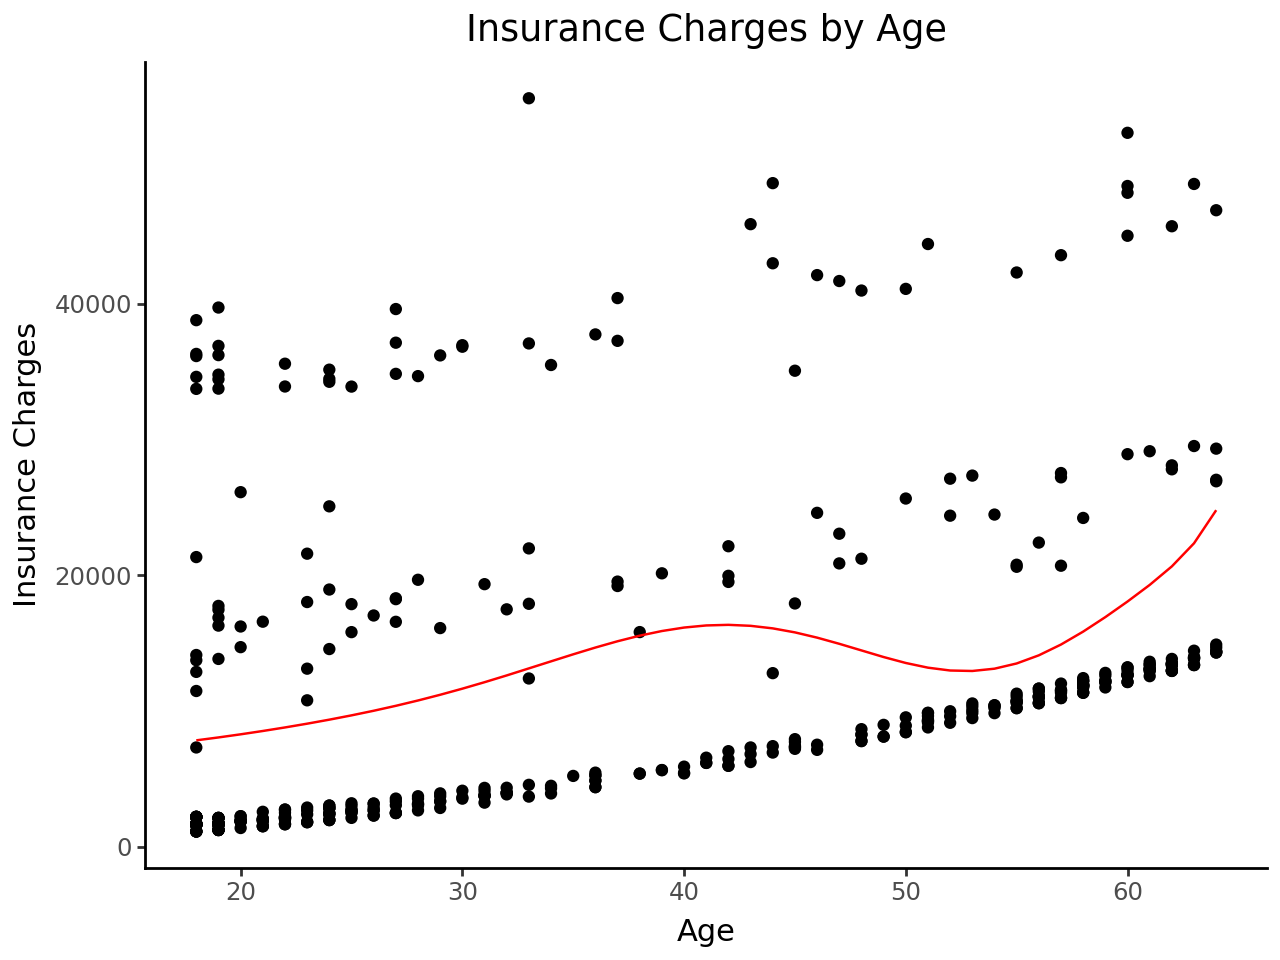

In [150]:
from plotnine import geom_point, geom_line

(ggplot(df_insurance, aes(x="age", y="charges")) +
geom_point() +
geom_line(aes(y="predicted_poly_12"), color="red") +
labs(x="Age", y="Insurance Charges", 
     title="Insurance Charges by Age") +
theme_classic())

**Part 4: New Data**

In [151]:
df_new_insurance = pd.read_csv("https://www.dropbox.com/s/sky86agc4s8c6qe/insurance_costs_2.csv?dl=1")

In [152]:
X_train = df_insurance.drop("charges", axis=1)
X_test = df_new_insurance.drop("charges", axis=1)
y_train = df_insurance[["charges"]]
y_test = df_new_insurance[["charges"]]

In [153]:
ct_age = ColumnTransformer(
  [
    ("standardize", StandardScaler(), ["age"])
  ],
  remainder = "drop"
)

pipeline = Pipeline(
  [("preprocessing", ct_age),
  ("linear_regression", LinearRegression())]
).set_output(transform="pandas")

pipeline_fit = pipeline.fit(X_train, y_train)
test_pred = pipeline.predict(X_test)
train_pred = pipeline.predict(X_train)

rmse_test = np.sqrt(mean_squared_error(test_pred, y_test))
rmse_test

11665.21052111598

In [154]:
ct_age_bmi = ColumnTransformer(
  [
    ("standardize", StandardScaler(), ["age", "bmi"])
  ],
  remainder = "drop"
)

pipeline = Pipeline(
  [("preprocessing", ct_age_bmi),
  ("linear_regression", LinearRegression())]
).set_output(transform="pandas")

pipeline_fit = pipeline.fit(X_train, y_train)
test_pred = pipeline.predict(X_test)
train_pred = pipeline.predict(X_train)

rmse_test = np.sqrt(mean_squared_error(test_pred, y_test))
rmse_test

11516.788011889987

In [155]:
ct_age_bmi_smoke = ColumnTransformer(
  [
    ("dummify", OneHotEncoder(sparse_output = False, drop="first"), ["smoker"]),
    ("standardize", StandardScaler(), ["age", "bmi"])
  ],
  remainder = "drop"
)

pipeline = Pipeline(
  [("preprocessing", ct_age_bmi_smoke),
  ("linear_regression", LinearRegression())]
).set_output(transform="pandas")

pipeline_fit = pipeline.fit(X_train, y_train)
test_pred = pipeline.predict(X_test)
train_pred = pipeline.predict(X_train)

rmse_test = np.sqrt(mean_squared_error(test_pred, y_test))
rmse_test

5947.902255536512

In [156]:
# Model 3

ct_pre = ColumnTransformer(
  [
    ("dummify", OneHotEncoder(sparse_output = False), ["smoker"]),
    ("standardize", StandardScaler(), ["age", "bmi"])
  ],
  remainder = "drop"
).set_output(transform = "pandas")

ct_inter = ColumnTransformer(
    [
      ("interaction1", PolynomialFeatures(interaction_only = True, include_bias=False), ["dummify__smoker_no", "standardize__age"]),
      ("interaction2", PolynomialFeatures(interaction_only = True, include_bias=False), ["dummify__smoker_no", "standardize__bmi"]),
      ("interaction3", PolynomialFeatures(interaction_only = True, include_bias=False), ["dummify__smoker_yes", "standardize__age"]),
      ("interaction4", PolynomialFeatures(interaction_only = True, include_bias=False), ["dummify__smoker_yes", "standardize__bmi"])
    ]
)

ct_keep = ColumnTransformer(
    [
      ("keep", FunctionTransformer(None), ["interaction1__standardize__age",
                                           "interaction1__dummify__smoker_no standardize__age",
                                           "interaction2__standardize__bmi",
                                           "interaction2__dummify__smoker_no standardize__bmi",
                                           "interaction3__dummify__smoker_yes standardize__age",
                                           "interaction4__dummify__smoker_yes standardize__bmi"])
    ],
    remainder = "drop"
)

pipeline_final = Pipeline(
  [("standardize", ct_pre),
   ("interaction", ct_inter),
   ("model_selection", ct_keep),
  ("linear_regression", LinearRegression())]
).set_output(transform="pandas")

pipeline = pipeline_final.fit(X_train, y_train)
test_pred = pipeline.predict(X_test)
train_pred = pipeline.predict(X_train)

rmse_test = np.sqrt(mean_squared_error(test_pred, y_test))
rmse_test

C:\Users\morag\anaconda3\Lib\site-packages\sklearn\preprocessing\_function_transformer.py:343: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.


11336.282299480987

In [157]:
ct_pre = ColumnTransformer(
  [
    ("dummify", OneHotEncoder(sparse_output = False), ["smoker"]),
    ("standardize", StandardScaler(), ["age", "bmi"])
  ],
  remainder = "drop"
).set_output(transform = "pandas")

ct_inter = ColumnTransformer(
    [
      ("interaction1", PolynomialFeatures(interaction_only = True, include_bias=False), ["dummify__smoker_no", "standardize__age"]),
      ("interaction2", PolynomialFeatures(interaction_only = True, include_bias=False), ["dummify__smoker_no", "standardize__age"]),
      ("interaction3", PolynomialFeatures(interaction_only = True, include_bias=False), ["dummify__smoker_yes", "standardize__age"]),
      ("interaction4", PolynomialFeatures(interaction_only = True), ["dummify__smoker_yes", "standardize__bmi"])
    ]
)

pipeline = Pipeline(
  [("standardize", ct_pre),
   ("interaction", ct_inter),
  ("linear_regression", LinearRegression())]
).set_output(transform="pandas")

pipeline_fit = pipeline.fit(X_train, y_train)
test_pred = pipeline.predict(X_test)

rmse_test = np.sqrt(mean_squared_error(test_pred, y_test))
r2_test = r2_score(test_pred, y_test)
rmse_test, r2_test

(4667.575052085673, 0.8063883517156851)

Based on the root mean square errors, it is best to use the fourth model, which accounts for age and bmi having interactions with smoker, but not including smoker in the model.

The root mean square error of this final model is 4708, with an R^2 of 0.797 if you were curious.

In [158]:
df_all_insurance = pd.concat([df_insurance, df_new_insurance])

X = df_all_insurance.drop("charges", axis=1)
y = df_all_insurance["charges"]

predicted = pipeline_fit.predict(X).flatten()
residuals = predicted - y

df_residuals = pd.DataFrame({
    "Predicted": predicted,
    "Residuals": residuals
})

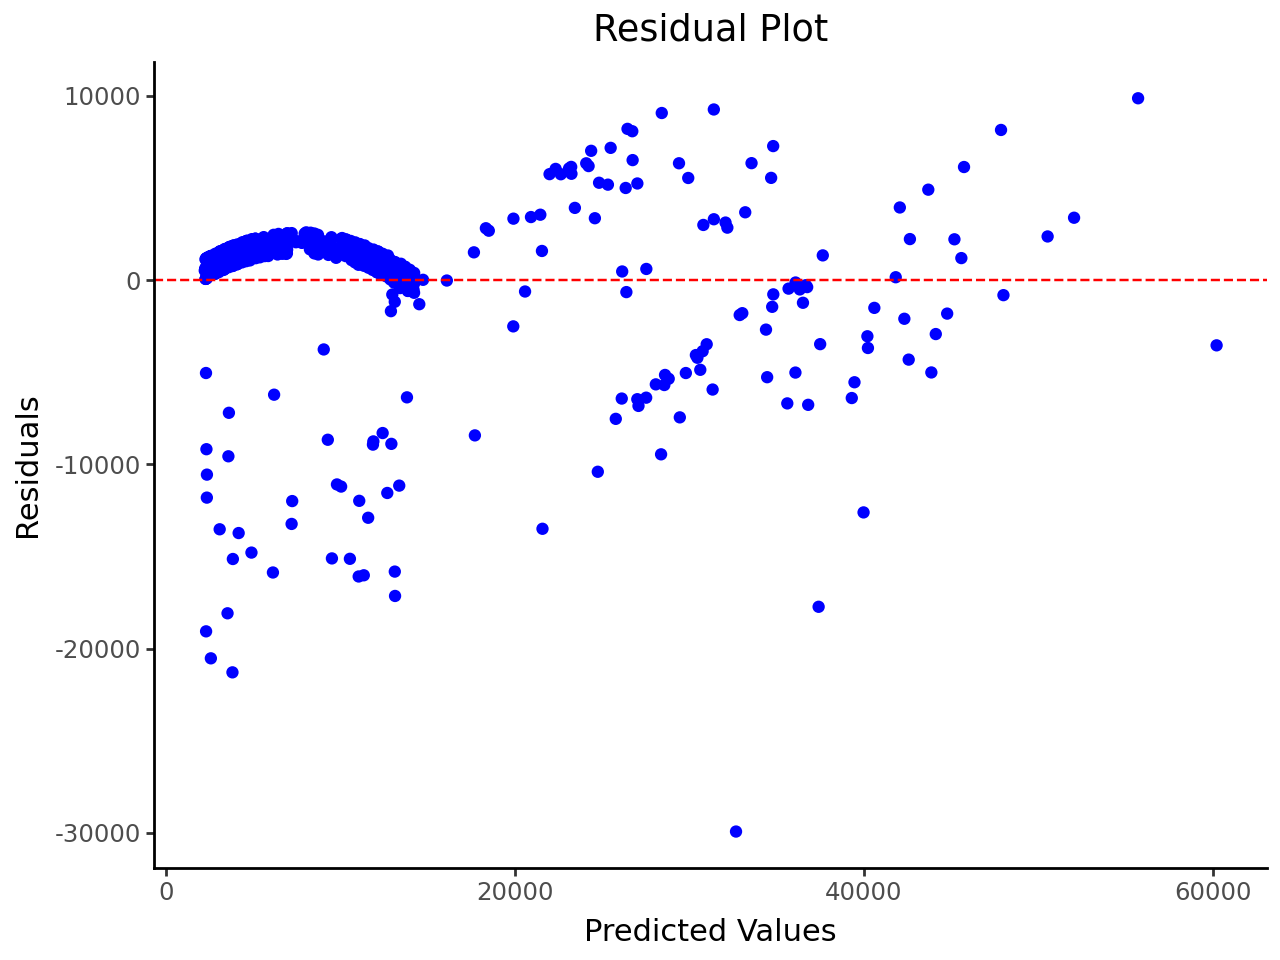

In [159]:
from plotnine import geom_hline

(ggplot(df_residuals, aes(x="Predicted", y="Residuals")) +
geom_point(color="blue") +
geom_hline(yintercept=0, color="red", linetype="dashed") +
labs(title="Residual Plot", x="Predicted Values", y="Residuals") +
theme_classic()
)

**Part 5: Full Exploration**

In [184]:
X = df_insurance.drop("charges", axis=1)
y = df_insurance

In [182]:
from sklearn.model_selection import GridSearchCV

ct_poly = ColumnTransformer(
  [
    ("dummify", OneHotEncoder(sparse_output=False, drop="first"), ["smoker"]),
    ("poly_age", PolynomialFeatures(), ["age"]),
    ("poly_bmi", PolynomialFeatures(), ["bmi"])
  ],
  remainder="drop"
)

lr_pipeline_poly = Pipeline(
  [("preprocessing", ct_poly),
   ("linear_regression", LinearRegression())]
).set_output(transform="pandas")

degrees = {
  'preprocessing__poly_age__degree': np.arange(1, 10),
  'preprocessing__poly_bmi__degree': np.arange(1, 10)
}

gscv = GridSearchCV(lr_pipeline_poly, degrees, cv=5, scoring='r2')

gscv_fitted = gscv.fit(X, y)

In [183]:
params_df = pd.DataFrame(gscv_fitted.cv_results_["params"])

results_df = params_df.assign(scores=gscv_fitted.cv_results_["mean_test_score"])

results_df.sort_values(by="scores", ascending=False)

,preprocessing__poly_age__degree,preprocessing__poly_bmi__degree,scores
30,4,4,0.776355
27,4,1,0.775807
3,1,4,0.775545
21,3,4,0.775233
39,5,4,0.775218
...,...,...,...
78,9,7,0.086799
76,9,5,0.083135
77,9,6,0.078185
79,9,8,-0.559572
